# Reproduction of grokking on modular addition problem

In [47]:
# Imports
import os
import datetime
import random
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp

import torch 
import torch.nn as nn
import torch.nn.functional as F

seed = 0
local_host = True if 'oveggeland' in list(notebookapp.list_running_servers())[0]['notebook_dir'] else False

## Step 1: Create dataset
This function handles dataset generation

In [13]:
def get_datasets(train_frac=0.5, p=97):

    # Create a randomly shuffled list of all possible combinations of input numbers: (i+j) % p = ?
    pairs = [(i, j, p) for i in range(p) for j in range(p)]
    random.shuffle(pairs)

    # Divide list into train and validation sets
    div = int(train_frac*len(pairs))
    train_set, val_set = pairs[:div], pairs[div:]
    
    return train_set, val_set
    

## Step 2: Define model
From Neel Nanda's work, transformer from scratch.

Source: https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=Jpfq01sZyPdC

In [49]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [50]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

## Step 3: Training the model

Helper functions for model training

In [51]:
def full_loss(model, data, device):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to(device)
    
    int_logits = np.argmax(logits.cpu().detach().numpy().squeeze(), axis=1).astype(int)
    int_labels = labels.int().cpu().numpy().squeeze()
    
    correct = int_logits == int_labels
    
    return cross_entropy_high_precision(logits, labels), correct.sum() / int_labels.size

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    
    return loss

In [52]:
def run_exp(run_name=f"test__"+datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Seeds for reproducability
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
    model = model.double()
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

    # Run formalities
    try:
        os.mkdir(save_root/run_name)
    except:
        print("Folder already exists")
        
    # Allocate lists for loss storage
    train_losses = []
    val_losses = []
    
    train_acc = []
    val_acc = []
    
    # Get dataset
    train_set, val_set = get_datasets(train_frac=train_frac, p=p)

    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_loss, epoch_train_acc = full_loss(model, train_set, device)
        train_losses.append(train_loss.item())

        val_loss, epoch_val_acc = full_loss(model, val_set, device)
        val_losses.append(val_loss.item())
        
        # Accuracy
        train_acc.append(epoch_train_acc)
        val_acc.append(epoch_val_acc)
    
        # Print status
        if epoch%100 == 0: 
            print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")
            print(f"{epoch}_{epoch_train_acc}_{epoch_val_acc}")

        # Calc gradients and perform backprop
        
        optimizer.zero_grad()
        train_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-5, norm_type=2.0)
        
        optimizer.step()
        scheduler.step()

        if val_loss.item() < stopping_thresh:
            break

    save_dict = {
        'model': model.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_acc': train_acc,
        'val_acc': val_acc
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Run experiments

In [55]:
lr=1e-3
d_model = 128
save_root = Path("checkpoints") # Path("PhD/IMT4392/project/modulo/checkpoints") if not local_host else Path("checkpoints")
stopping_thresh = -1
seed = 10
fn_name = 'add' #['add', 'subtract', 'x2xyy2','rand']

# Model parameters
num_layers = 2
batch_style = 'full'
p = 113
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0, "Error with parameters"
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]


# Loop over parameters of interest and run experiments
train_fracs = [0.1]
decays = [1.0]
tag = "demo"

num_epochs = 1000

for frac in train_fracs:
    for decay in decays:
        train_frac = frac
        weight_decay = decay
        
        exp_name = f"{tag}_{weight_decay}decay_{train_frac}train"
        run_exp(exp_name)

Folder already exists
0_1.5970_1.5922
0_0.014106583072100314_0.00817889149917341
100_-1.1248_2.6352
100_0.9968652037617555_0.004698512137823023
200_-6.6930_3.3160
200_1.0_0.006351692334464457
300_-8.8161_3.4856
300_1.0_0.007221787174802053
400_-9.6727_3.6443
400_1.0_0.0074828156269033325
500_-10.6506_3.5821
500_1.0_0.007047768206734534
600_-9.7358_3.4897
600_1.0_0.007743844079004612
700_-7.8812_3.3192
700_1.0_0.007917863047072132
800_-10.4451_3.5346
800_1.0_0.007308796658835813
900_-9.6058_3.4824
900_1.0_0.006525711302531976
Saved model to checkpoints/add_1.0decay_0.1train/final.pth


# Step 5: Analysis

## Single grokking example

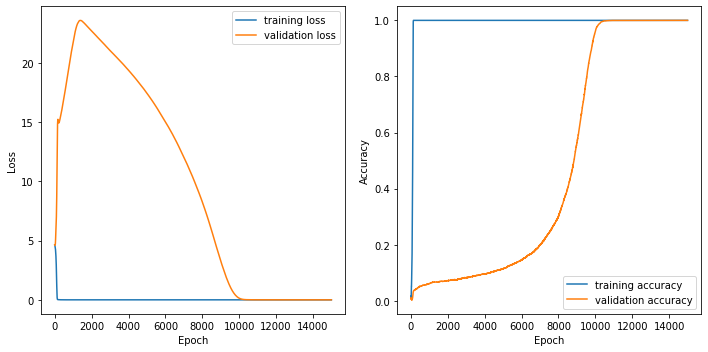

In [56]:
# Show grokking effect
load_dict = torch.load(f"checkpoints/add_1.0decay_0.3train/final.pth", map_location=torch.device('cpu'))
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].plot(load_dict['train_losses'], label='training loss')
axs[0].plot(load_dict['val_losses'], label="validation loss")

axs[1].plot(load_dict['train_acc'], label='training accuracy')
axs[1].plot(load_dict['val_acc'], label="validation accuracy")
    
axs[0].set_xlabel("Epoch")
axs[1].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()


plt.tight_layout()

## The effect of training size ratio

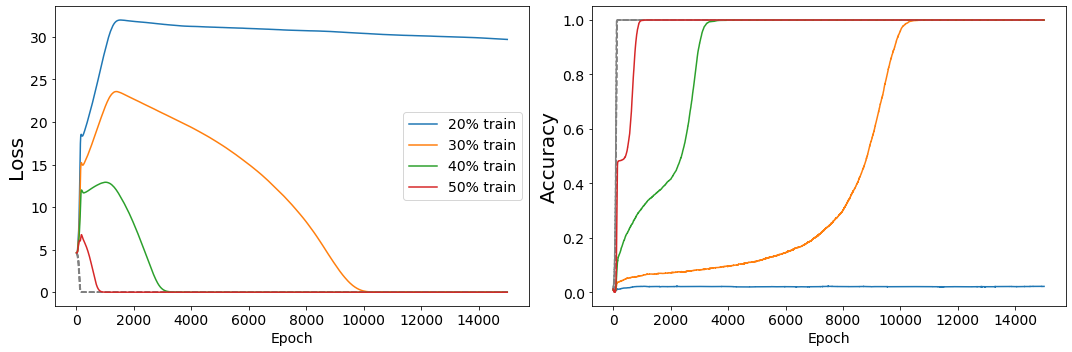

In [45]:
# Show how the amount of training data effects fraccing
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

decay = 1.0
train_fracs = [0.2, 0.3, 0.4, 0.5]
tag = 'add'

for i, frac in enumerate(train_fracs):
    exp_name = f"{tag}_{decay}decay_{frac}train"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth", map_location=torch.device('cpu'))
    
    axs[0].plot(load_dict['train_losses'], c='gray', linestyle='dashed')
    axs[0].plot(load_dict['val_losses'], label=f"{int(100*frac)}% train")
    
    axs[1].plot(load_dict['train_acc'], c='gray', linestyle='dashed', label=f"{int(100*frac)}% train")
    axs[1].plot(load_dict['val_acc'], label=f"{int(100*frac)}% val")
    

axs[0].set_xlabel("Epoch", size=14)
axs[0].set_ylabel("Loss", size=20)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].set_xlabel("Epoch", size=14)
axs[1].set_ylabel("Accuracy", size=20)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[0].legend(prop={'size':14})

plt.tight_layout()
plt.savefig("modulo_training_size.svg")

## The effect of weigth decay 

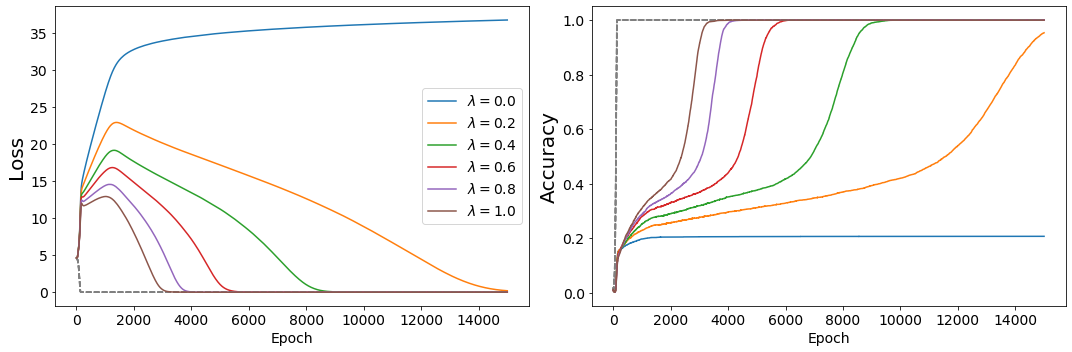

In [46]:
# Show how the amount of training data effects fraccing
fig, axs = plt.subplots(1, 2, figsize=(15, 5)) 

train_frac = 0.4
decays = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
tag = 'add'

for i, decay in enumerate(decays):
    exp_name = f"{tag}_{decay}decay_{train_frac}train"
    load_dict = torch.load(f"checkpoints/{exp_name}/final.pth",  map_location=torch.device('cpu'))
    
    axs[0].plot(load_dict['train_losses'], c='gray', linestyle='dashed')
    axs[0].plot(load_dict['val_losses'], label=f"$\lambda = {decay}$")
    
    axs[1].plot(load_dict['train_acc'], c='gray', linestyle='dashed')
    axs[1].plot(load_dict['val_acc'], label=f"$\lambda = {decay}$")
    

axs[0].set_xlabel("Epoch", size=14)
axs[0].set_ylabel("Loss", size=20)
axs[0].tick_params(axis='both', which='major', labelsize=14)

axs[1].set_xlabel("Epoch", size=14)
axs[1].set_ylabel("Accuracy", size=20)
axs[1].tick_params(axis='both', which='major', labelsize=14)

axs[0].legend(prop={'size':14})


plt.tight_layout()
plt.savefig("modulo_weight_decay.svg")